In [2]:
import numpy as np
import cupy as cp
import ray
import astropy.units as u
from astropy.io import fits
from IPython.display import clear_output
import time
from pathlib import Path
from matplotlib.patches import Circle
from importlib import reload

import warnings
warnings.filterwarnings("ignore")

import poppy

import logging, sys
poppy_log = logging.getLogger('poppy')
poppy_log.setLevel('DEBUG')
logging.basicConfig(stream=sys.stdout, level=logging.INFO)
poppy_log.disabled = True

import cgi_phasec_poppy as cgi
from cgi_phasec_poppy.math_module import xp
reload(cgi)

import misc_funs as misc

iwa = 6
owa = 20

data_dir = cgi.data_dir

dm1_best = fits.getdata('spc_wide_band4_best_contrast_dm1.fits')
dm2_best = fits.getdata('spc_wide_band4_best_contrast_dm2.fits')

# Test monochromatic PSFs.

0.1 0.0072010264910560605 arcsec / pix


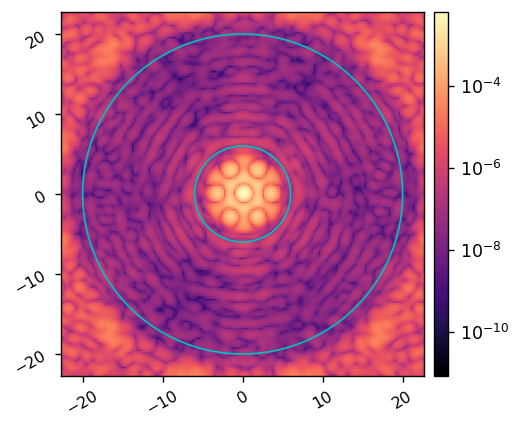

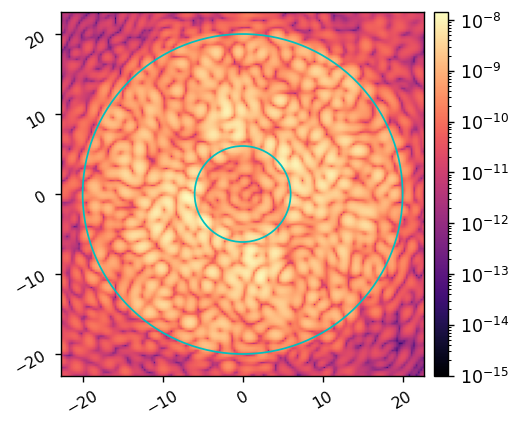

In [19]:
reload(cgi.cgi)
mode = cgi.cgi.CGI(cgi_mode='spc-wide', 
               npsf=150,
               use_pupil_defocus=True, 
               use_opds=True,
            #    source_flux=3.840e+08*u.ph/(u.s * u.m**2),
               )

mode.set_dm1(dm1_best)
mode.set_dm2(dm2_best)

mode.use_fpm = False
ref_unocc_im = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(ref_unocc_im, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

# mode.Imax_ref = ref_unocc_im.max()
mode.use_fpm = True

image = mode.snap()

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(image, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

# if poppy.accel_math._USE_CUPY:
#     misc.save_fits(data_dir/'spc-wide_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
# else:
#     misc.save_fits(data_dir/'spc-wide_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [20]:
mode.DM1.inclination_y

9.65

In [5]:
cgi.data_dir

PosixPath('/home/kianmilani/Projects/roman-cgi-phasec-data')

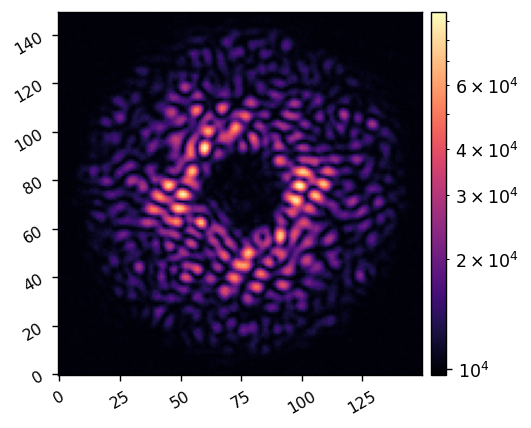

In [3]:
from emccd_detect import emccd_detect

meta_path = Path('/home/kianmilani/Projects/emccd_detect/emccd_detect/emccd_detect/util/metadata.yaml')

em_gain = 25
full_well_image=60000.  # e-
full_well_serial=100000.  # e-
#status=1,
dark_current=0.0028  # e-/pix/s
cic=0.02  # e-/pix/frame
read_noise=100.  # e-/pix/frame
bias=10000.  # e-
qe=0.9
cr_rate=0.  # hits/cm^2/s
pixel_pitch=13e-6  # m
eperdn=1 #7.,
nbits=32#14,
numel_gain_register=604

emccd = emccd_detect.EMCCDDetect(em_gain=em_gain,
                                    full_well_image=full_well_image,  # e-
                                    full_well_serial=full_well_serial,  # e-
                                    #status=status,
                                    dark_current=dark_current,  # e-/pix/s
                                    cic=cic,  # e-/pix/frame
                                    read_noise=read_noise,  # e-/pix/frame
                                    bias=bias,  # e-
                                    qe=qe,
                                    cr_rate=cr_rate,  # hits/cm^2/s
                                    pixel_pitch=pixel_pitch,  # m
                                    eperdn=eperdn,
                                    nbits=nbits,
                                    numel_gain_register=numel_gain_register,
                                    meta_path=meta_path
                                    )

# emccd = emccd_detect.EMCCDDetect(em_gain=25)

frametime = 1
sim_sub_frame = emccd.sim_sub_frame(image.get(), frametime)

misc.imshow1(sim_sub_frame, lognorm=True)

# sim_full_frame = emccd.sim_full_frame(image.get(), frametime)

# misc.imshow1(sim_full_frame, lognorm=True)


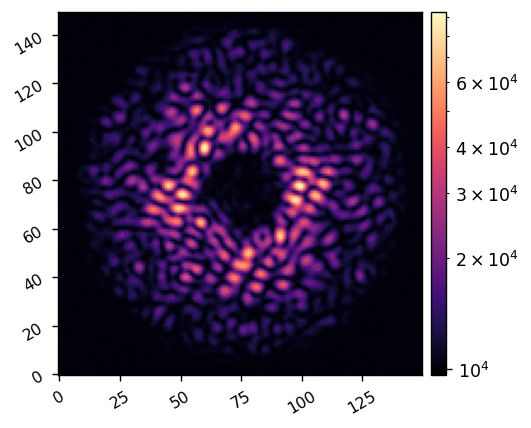

In [5]:
mode.emccd = emccd
mode.exp_time = 1

frame = mode.snap()

misc.imshow1(frame, lognorm=True)

In [25]:
emccd.em_gain

1.0

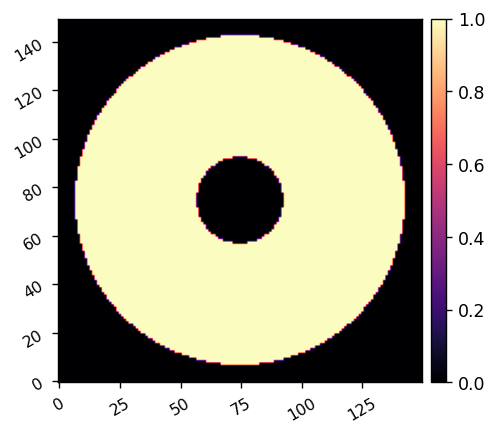

array(1.1116528e-09)

In [8]:
import lina
mask = lina.utils.create_annular_focal_plane_mask(mode, 5.4, 20.6, plot=True)

xp.mean(image[mask])

In [25]:
from cgi_phasec_poppy.math_module import ensure_np_array
import lina
from lina.imshows import *
reload(lina.imshows)

<module 'lina.imshows' from '/home/kianmilani/Projects/lina/lina/imshows.py'>

In [34]:
import scipy
proper_im = fits.getdata('proper_spc_wfov_825_aberrated.fits')

poppy_im = scipy.ndimage.shift(np.rot90(np.rot90(ensure_np_array(image))), (1,1))

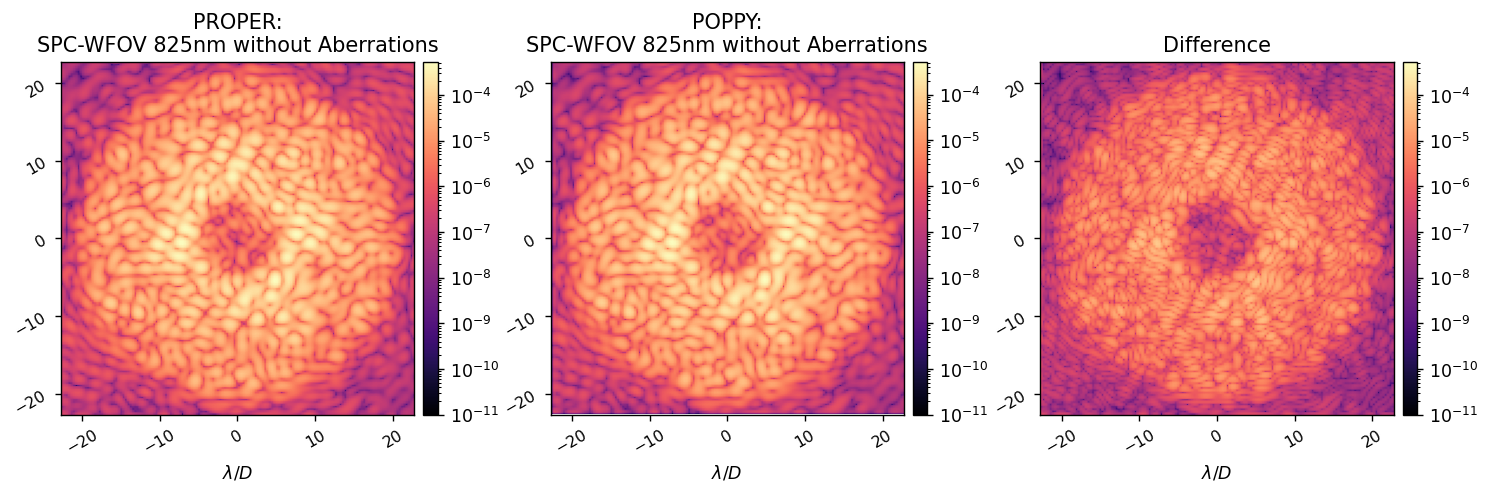

In [35]:
imname = 'SPC-WFOV 825nm without Aberrations'
imshow3(proper_im, poppy_im, abs(proper_im-poppy_im),
        'PROPER:\n'+imname, 'POPPY:\n'+imname, 'Difference', 
        lognorm1=True, lognorm2=True, 
        vmin1=1e-11, vmin2=1e-11, 
        lognorm3=True,
        vmax3=np.max(np.concatenate([proper_im, poppy_im])),
        vmin3=1e-11,
        pxscl=mode.psf_pixelscale_lamD,
        xlabel='$\lambda/D$'
#         vmax3=10,
       )

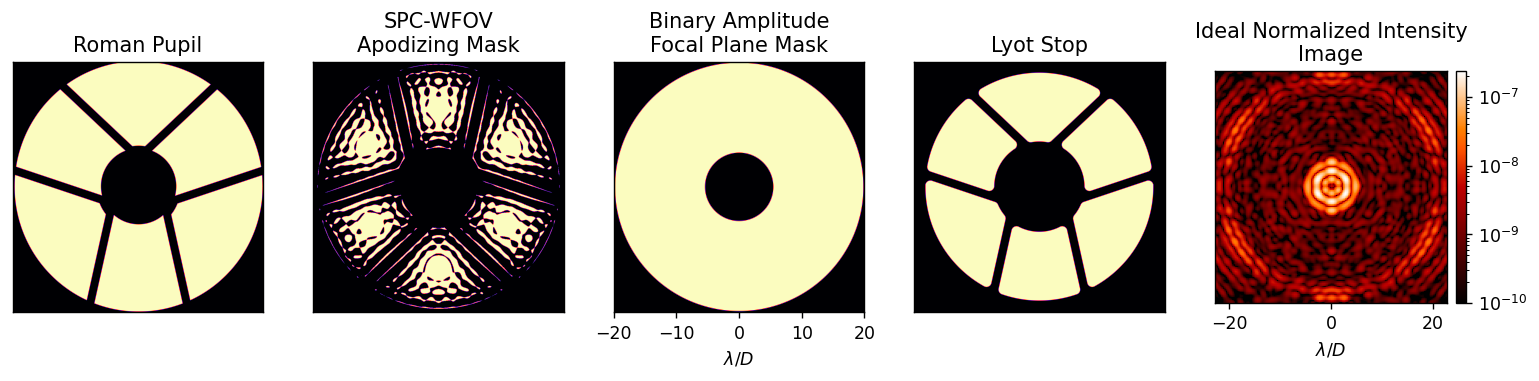

In [56]:
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm, Normalize
from mpl_toolkits.axes_grid1 import make_axes_locatable


fig,ax = plt.subplots(nrows=1,ncols=5, dpi=125, figsize=(15,5))

ax[0].imshow(ensure_np_array(mode.PUPIL.amplitude), cmap='magma')
ax[0].set_title('Roman Pupil')
ax[0].set_xticks([])
ax[0].set_yticks([])

im = ax[1].imshow(ensure_np_array(mode.SPM.amplitude), cmap='magma')
ax[1].set_title('SPC-WFOV\nApodizing Mask')
ax[1].set_xticks([])
ax[1].set_yticks([])
# divider = make_axes_locatable(ax[1])
# cax = divider.append_axes("right", size="4%", pad=0.075)
# fig.colorbar(im, cax=cax)

ext = mode.FPM.pixelscale_lamD * mode.FPM.amplitude.shape[0]//2
ax[2].imshow(ensure_np_array(mode.FPM.amplitude), cmap='magma', extent=[-ext, ext, -ext, ext])
ax[2].set_title('Binary Amplitude\nFocal Plane Mask')
ax[2].set_xlabel('$\lambda/D$')
ax[2].set_yticks([])

ax[3].imshow(ensure_np_array(mode.LS.amplitude), cmap='magma')
ax[3].set_title('Lyot Stop')
ax[3].set_xticks([])
ax[3].set_yticks([])

# post_lyot = utils.pad_or_crop(np.abs(wfs[6]), mode.npix+10)
# ax[3].imshow(post_lyot, cmap='magma', norm=Normalize(vmax=pre_lyot.max()))
# ax[3].set_title('Post-Lyot Stop')
# ax[3].set_xticks([])
# ax[3].set_yticks([])

ext = mode.psf_pixelscale_lamD * mode.npsf/2
im = ax[4].imshow(ensure_np_array(psf), cmap='gist_heat', norm=LogNorm(vmin=1e-10), extent=[-ext, ext, -ext, ext])
ax[4].set_title('Ideal Normalized Intensity\nImage')
ax[4].set_xlabel('$\lambda/D$')
ax[4].set_yticks([])
divider = make_axes_locatable(ax[4])
cax = divider.append_axes("right", size="4%", pad=0.075)
fig.colorbar(im, cax=cax)

Propagating wavelength 825.000 nm.


c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')
c:\users\kian\documents\src\poppy\poppy\geometry.py:215: UserWarning: filled_circle_aa may not yield exact results for grey pixels when pixel scale <1
  warnings.warn('filled_circle_aa may not yield exact results for grey pixels when pixel scale <1')


PSF calculated in 0.933s


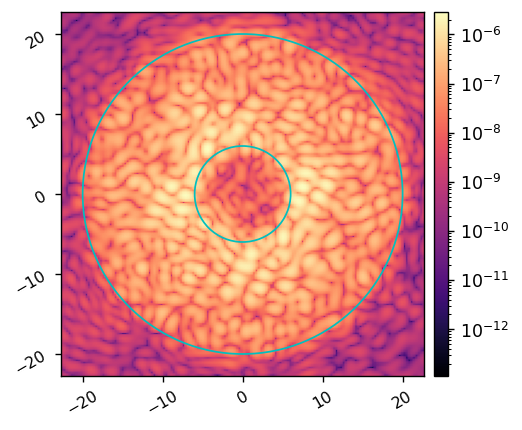

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-wide_opds_psf_gpu.fits


In [8]:
mode = cgi.CGI(cgi_mode='spc-wide', 
               npsf=150,
               use_pupil_defocus=True, use_opds=True)

# mode.set_dm1(dm1_flat)
# mode.set_dm2(dm2_flat)

wf = mode.calc_psf(quiet=False)
psf = np.abs(wf)**2

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf, lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-wide_opds_psf_gpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-wide_opds_psf_cpu.fits', psf, header={'PIXELSCL':mode.psf_pixelscale_lamD})

In [22]:
%%timeit
wf = mode_opds.calc_psf(quiet=True)

349 ms ± 1.36 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


# Test broadband PSFs with GPU parallelization.

### Create the actors to calculate each individual PSF/image with ray.remote() actors.

num_gpus can be set to whatever fractional GPU the user desires

In [10]:
CGI = ray.remote(cgi.CGI) # make a ray actor class from the original CGI class

wavelength_c = 825e-9*u.m

nlam = 5
bandwidth = 0.10
minlam = wavelength_c * (1 - bandwidth/2)
maxlam = wavelength_c * (1 + bandwidth/2)
wavelengths = np.linspace( minlam, maxlam, nlam )

kwargs = {'cgi_mode':'spc-wide',
          'npsf':150,
          'use_pupil_defocus':True,
          'use_opds':False}
actors = []
for i in range(nlam):
    actors.append(CGI.remote(wavelength=wavelengths[i], **kwargs))

### Calculate each image by calling the remote function of each actor. 

In [16]:
time

<module 'time' (built-in)>

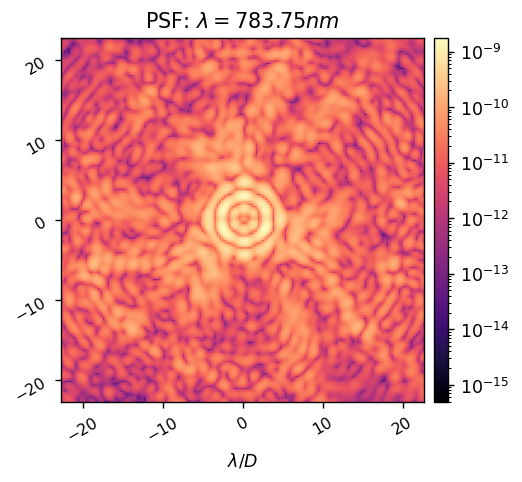

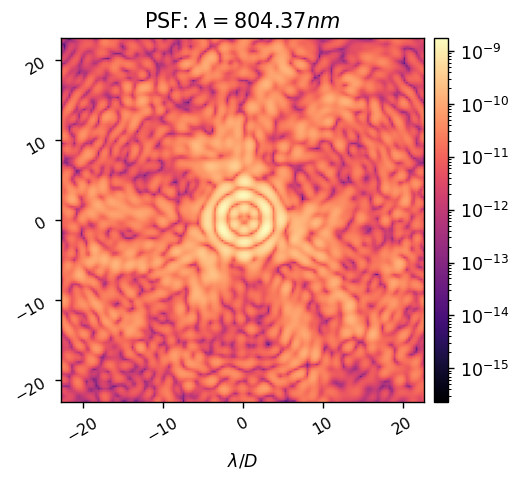

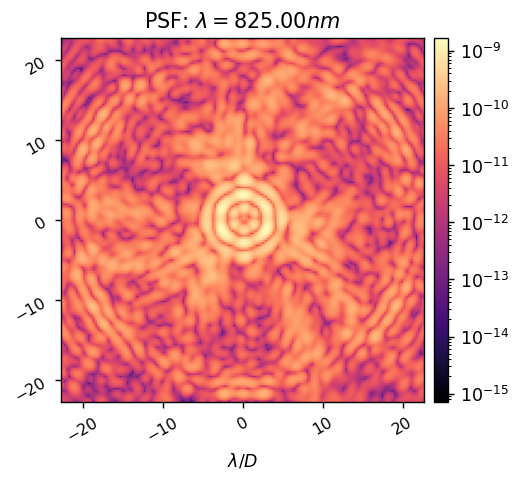

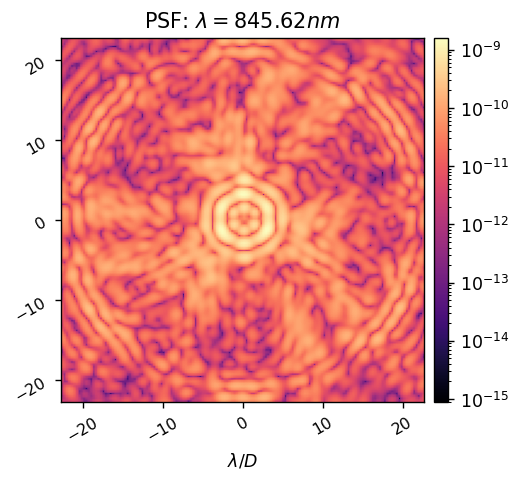

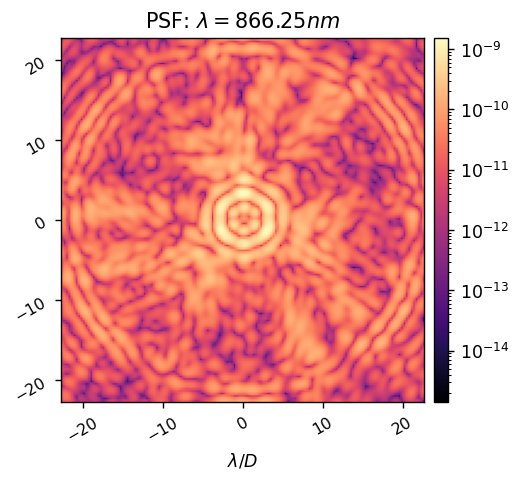

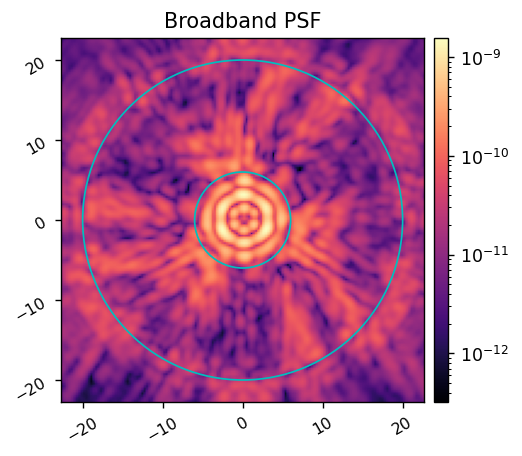

Saved data to:  C:\Users\Kian\Documents\data-files\roman-cgi-phasec-data\spc-wide_psf_broad_gpu.fits


In [11]:
pending_ims = []
for i in range(len(actors)):
    future_ims = actors[i].snap.remote()
    pending_ims.append(future_ims)
ims = ray.get(pending_ims)
clear_output()

for i in range(nlam):
    misc.imshow1(ims[i], 
                 'PSF: $\lambda={:.2f}$'.format(wavelengths[i].to(u.nm)), 
                 pxscl=mode.psf_pixelscale_lamD, xlabel='$\lambda/D$',
                 lognorm=True)
    
psf_broad = np.sum(ims, axis=0)/nlam

patches = [Circle((0, 0), iwa, color='c', fill=False), Circle((0, 0), owa, color='c', fill=False)]
misc.imshow1(psf_broad, 'Broadband PSF', lognorm=True, pxscl=mode.psf_pixelscale_lamD, patches=patches)

if poppy.accel_math._USE_CUPY:
    misc.save_fits(data_dir/'spc-wide_psf_broad_gpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})
else:
    misc.save_fits(data_dir/'spc-wide_psf_broad_cpu.fits', psf_broad, header={'PIXELSCL':mode.psf_pixelscale_lamD})